# Artificial intelligence for Ionospheric perturbations DEtections (AIDE)
AIDE allows you to scan vTEC records to detect co-seismic ionospheric perturbations. AIDE software consists of a Machine-Learning based detector, arrival-time picker, and an associator across GNSS satellite networks.

Reference paper: Brissaud, Q., & Astafyeva, E. (2021). Near-real-time detection of co-seismic ionospheric disturbances using machine learning. Geophysical Journal International. doi: 10.1093/gji/ggac167

<center><img src="scheme_ML_improved.png" width="600"/></center>
Figure: AIDE workflow

In [5]:
%matplotlib inline
import numpy as np
from pdb import set_trace as bp
import pandas as pd
import seaborn as sns

import AIDE, detector, compute_params_waveform, read_data, train_est, train_wave_picker, utils_paper, associator, constants

## Directories and data/model loading
First, select where vTEC data are located and where figures should be generated

In [40]:
## Directories
main_dir = '/staff/quentin/Documents/Projects/ML_TEC/'
dir_dict = {
    'DIR_FIGURES': main_dir + 'figures/',
    'DIR_DATA': '/adhocdata/infrasound/2023_ML_TEC/data/'
    #'DIR_DATA': main_dir + 'data/'
}

Then, add entries to `load_dict` in order to load data and/or models instead of re-generating them. Comment line or remove entry to re-generate.

In [34]:
## Loading previously-generated data/models
load_dict = {
    'est': main_dir + 'figures/model_arr4_noise4_snr1_5.0_pFalse/forest_est_s500.0_m0.7_n1000.0_w720.0.pkl',
    'data': main_dir + 'figures/model_arr4_noise4_snr1_5.0_pFalse/data_s500.0_m0.7_n1000.0_w720.0.pkl',
    'features': main_dir + 'figures/model_arr4_noise4_snr1_5.0_pFalse/features_features_m0.7_w720.0.csv',
    'features-picker': '/adhocdata/infrasound/2023_ML_TEC/data/features_picker_w720.0_d0.7.csv',
    'est-picker': main_dir + 'figures/random_est_picker_w720.0_d0.7_bTrue.joblib',
    'load_tec_data': True
    #'detections': main_dir + 'figures/detected_arrivals_Iquique_afterreview_detrend.csv',
    #'probas': main_dir + 'figures/probas_all_waveforms_Iquique_afterreview_detrend.csv',
    #'associations': main_dir + 'Iquique_afterreview_associations.csv',
    #'associations_time_steps': main_dir + 'Iquique_afterreview_associations_time_steps.csv',
}

In [45]:
np.round(1.0001)

1.0

## Create an AIDE model instance
To create a new AIDE model instance, you need to: 1) load vTEC data, 2) create an instance of the ML detector, and 3) create an instance of the ML picker

In [41]:
import importlib, AIDE, train_est
importlib.reload(AIDE)
importlib.reload(train_est)

## Create detection model
one_model = AIDE.AIDE(dir_dict)
one_model.load_data(load_dict)
one_model.load_RF_detector(load_dict)
one_model.load_RF_picker(load_dict)

KeyError: 'diff-t'

## Run the detector and arrival-time picker
Run the detector with input parameters defined in `detection_options` over satellite network and events defined in `detection_network`.
- `nb_picks` (int): Number of picks to use to confirm a detections
- `plot_probas` (bool): Whether or not you want to plot the detection probabilities for each input vTEC waveform
- `focus_on_arrival` (bool): Whether or not you want to only perform detections around the true detection time. You need `tec_data_param` entries for this.
- `focus_arrival_shift` (s, float): If `focus_on_arrival=True`, time window used to extract waveforms
- `nb_CPU` (int): Number of CPUs to deploy detections using multiprocessing

In [36]:
import importlib, train_est
importlib.reload(train_est)

events = ['Tohoku_1s']

## Perform detection
detection_network = {
    'name': 'test',
    'events': events,
    'satellites': ['G26'],#one_model.tec_data.loc[one_model.tec_data['event'].isin( events ), 'satellite'].unique().tolist(),
    'stations': one_model.tec_data.loc[one_model.tec_data['event'].isin( events ), 'station'].unique().tolist(),
    'time_end': one_model.tec_data.loc[one_model.tec_data['event'].isin( events ), 'time_s'].max()
}

detection_options = { 
    'nb_picks': 5, 
    'plot_probas': True, 
    'focus_on_arrival': False, 
    'focus_arrival_shift': 1000., 
    'nb_CPU': 20
}
one_model.run_detections(load_dict, detection_network, **detection_options)

No data requested available


TypeError: cannot unpack non-iterable NoneType object

In [39]:
one_model.tec_data

,epoch,UT,LOS,az,lat,lon,sTEC,vTEC,time_s,station,satellite,doy,year,event,sampling,file,only_for_testing
0,1152,9.600000,37.54185,110.56688,32.276625,136.266730,0.000,0.0000,34560.0000,0084,G15,249,4,Kii_30s,29.9988,rtTEC_0084_G15_249_04,False
1,1153,9.608333,37.66278,110.30101,32.292558,136.260054,-0.062,-0.0402,34589.9988,0084,G15,249,4,Kii_30s,29.9988,rtTEC_0084_G15_249_04,False
2,1154,9.616667,37.78279,110.03396,32.308416,136.253441,-0.127,-0.0825,34620.0012,0084,G15,249,4,Kii_30s,29.9988,rtTEC_0084_G15_249_04,False
3,1155,9.625000,37.90189,109.76573,32.324202,136.246889,-0.187,-0.1217,34650.0000,0084,G15,249,4,Kii_30s,29.9988,rtTEC_0084_G15_249_04,False
4,1156,9.633333,38.02006,109.49633,32.339916,136.240399,-0.256,-0.1670,34679.9988,0084,G15,249,4,Kii_30s,29.9988,rtTEC_0084_G15_249_04,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6159,1375,11.458333,27.27347,47.03121,33.879907,134.336571,-0.585,-0.3031,41249.9988,1093,G15,249,4,Kii_30s,29.9988,rtTEC_1093_G15_249_04,False
6160,1376,11.466667,27.10930,46.88596,33.903619,134.350929,-0.479,-0.2472,41280.0012,1093,G15,249,4,Kii_30s,29.9988,rtTEC_1093_G15_249_04,False
6161,1377,11.475000,26.94460,46.74213,33.927530,134.365521,-0.405,-0.2082,41310.0000,1093,G15,249,4,Kii_30s,29.9988,rtTEC_1093_G15_249_04,False
6162,1378,11.483333,26.77936,46.59971,33.951643,134.380353,-0.311,-0.1592,41339.9988,1093,G15,249,4,Kii_30s,29.9988,rtTEC_1093_G15_249_04,False


## Run the associator
Run the associator with the inputs parameters provided in `association_options`.
- `max_radius_search` (m, float): Maximum distance between two ionospheric points for association
- `velocity_search_max` (km/s, float): Maximum horizontal propagation velocity between two ionospheric points for association
- `velocity_search_min` (km/s, float): Minimum horizontal propagation velocity between two ionospheric points for association
- `save_associations` (bool): Whether or not you want to save the `DataFrame` containing associated arrivals
- `association_name` (str): Name for this association dataset

Kii_30s
Time:  37110.0
Time:  37140.0
Time:  37170.0
Time:  37200.0
Time:  37230.0
Time:  37260.0
Time:  37290.0
Time:  37320.0
Time:  37350.0
Time:  37380.0
Time:  37410.0
Time:  37440.0
Time:  37470.0
Time:  37500.0
Time:  37530.0
Time:  37560.0
Time:  37590.0
Time:  37620.0
Time:  37650.0
Time:  37680.0
Time:  37710.0
Time:  37740.0
Time:  37770.0
Time:  37800.0
Time:  37830.0
Time:  37860.0
Time:  37890.0
Time:  37920.0
Time:  37950.0
Time:  37980.0
Time:  38010.0
Time:  38040.0
Time:  38070.0
Time:  38100.0
Time:  38130.0
Time:  38160.0
Time:  38190.0
Time:  38220.0
Time:  38250.0
Time:  38280.0
Time:  38310.0
Time:  38340.0
Time:  38370.0
Time:  38400.0
Time:  38430.0
Time:  38460.0
Time:  38490.0
Time:  38520.0
Time:  38550.0
Time:  38580.0
Time:  38610.0
Time:  38640.0
Time:  38670.0
Time:  38700.0
Time:  38730.0
Time:  38760.0
Time:  38790.0
Time:  38820.0
Time:  38850.0
Time:  38880.0
Time:  38910.0
Time:  38940.0
Time:  38970.0
Time:  39000.0
Time:  39030.0
Time:  39060.0
Ti

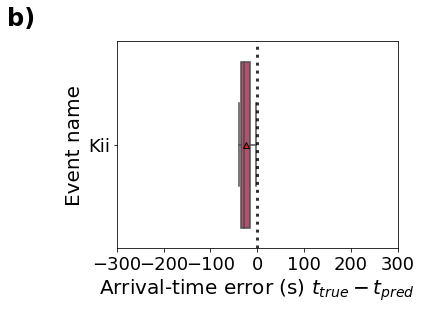

In [32]:
## Create association list
association_options = {
    'max_radius_search': 500., 
    'velocity_search_max': 50., 
    'velocity_search_min': 0.65, 
    'save_associations': True, 
    'association_name': 'test'
}
one_model.run_association(load_dict, **association_options)

AA
Kii
BB
CC 0
CC 1
CC 2
DD
EE
FF
LLMM
Ww
XX


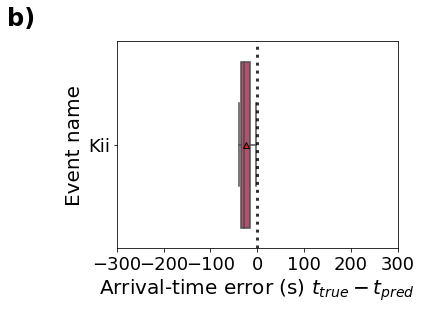

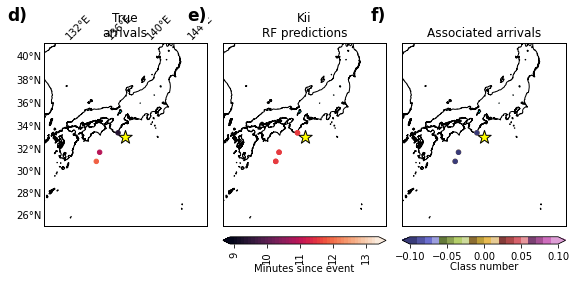

In [33]:
## Create Figure
first_detections = utils_paper.create_arrival_time_plot(one_model.detections, one_model.options, offset=500., nb_pts_picker=5, quantile_threshold=0.8)
utils_paper.plot_image_iono(one_model.tec_data, one_model.tec_data_param, first_detections, one_model.options, associations=one_model.associations, add_fault=False, add_inset_fault=False, unknown='slip', rotation=25., vmin=6., vmax=11., offset_source_lat=8., offset_source_lon=8., first_label='d', hion_dict={}, add_new_waveform={}, add_new_waveform_class={}, ext_name='_test')